# Predict Survival Rate on the Titanic

### Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import lux
from lux.vis.VisList import VisList 
#lux.config.plotting_backend = "matplotlib"
lux.config.plotting_backend = "vegalite"

In [3]:
import missingno as msno
%matplotlib inline
from plotnine import *
from matplotlib import pyplot as plt

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Load Datasets

In [6]:
df = pd.read_csv('../00_Data/train.csv')
test_df = pd.read_csv('../00_Data/test.csv')

### Pre-Process Datasets

In [7]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [8]:
df['Fare'] = df['Fare'].replace(0, df['Fare'].mean())
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Sex'] = df['Sex'].apply(lambda val: 1 if val == 'male' else 0)
df['Embarked'] = df['Embarked'].map({'S' : 0, 'C': 1, 'Q': 2})

In [9]:
test_df['Fare'] = test_df['Fare'].replace(0, test_df['Fare'].mean())
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)
test_df['Sex'] = test_df['Sex'].apply(lambda val: 1 if val == 'male' else 0)
test_df['Embarked'] = test_df['Embarked'].map({'S' : 0, 'C': 1, 'Q': 2})

### Exploratory Data Analysis

In [10]:
all_features = VisList(["?", "Survived"], df)
all_features

LuxWidget(recommendations=[{'action': 'Vis List', 'description': 'Shows a vis list defined by the intent', 'vs…

### Missing Data Visual

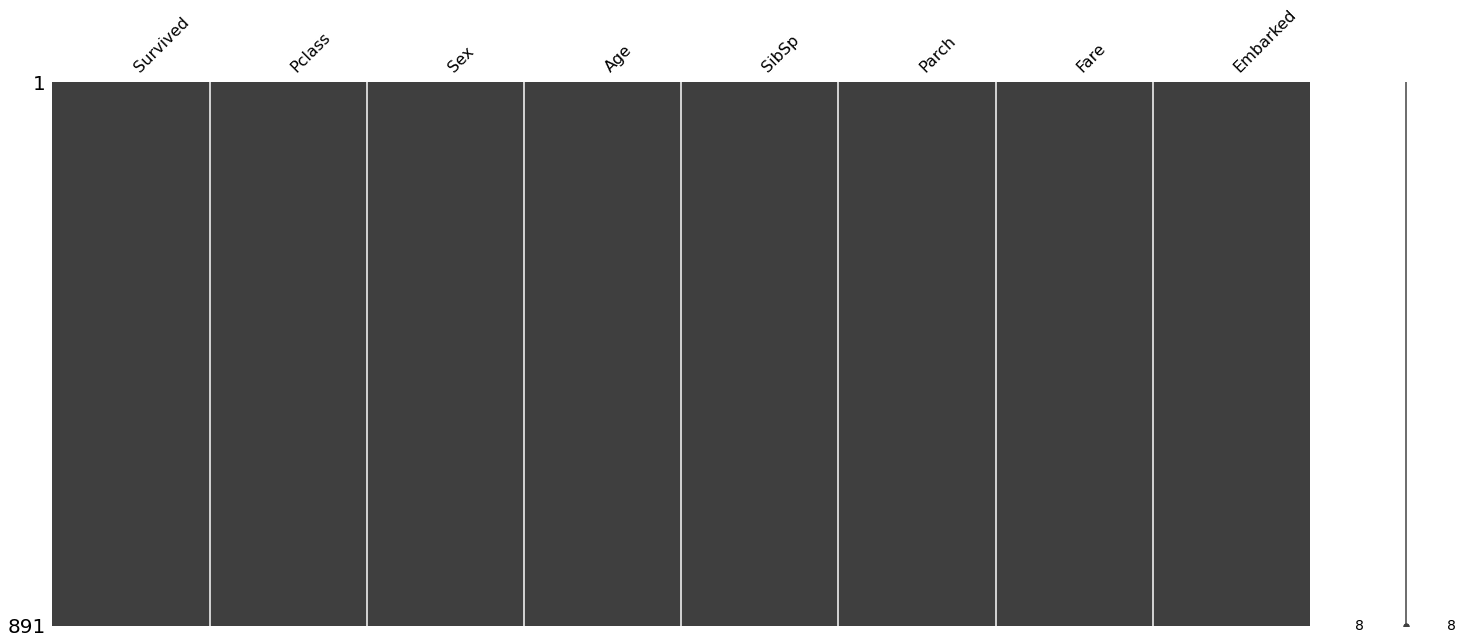

In [11]:
fig = msno.matrix(df)

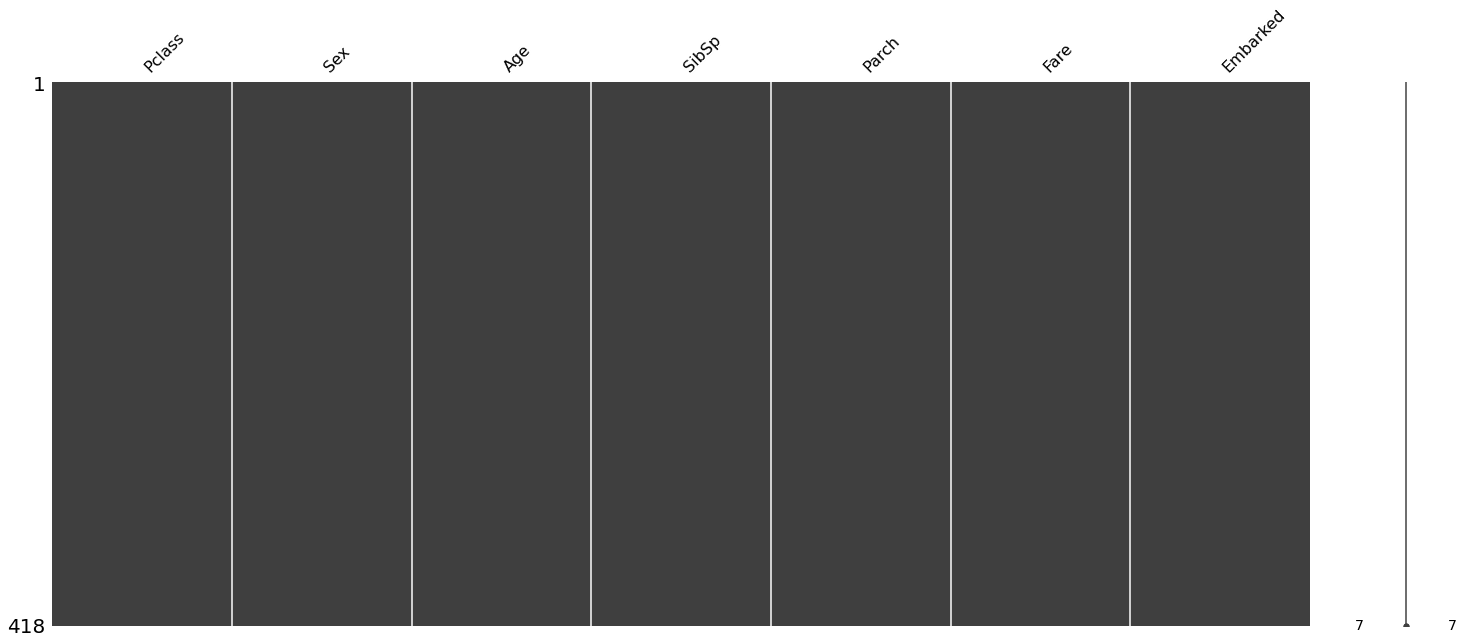

In [12]:
fig = msno.matrix(test_df)

### Model Building

In [13]:
# Prepare dataframe for train-test split
y = df['Survived'].copy()
x = df.copy()
x = x.drop(['Survived'], axis=1).copy()

In [14]:
# Train-Test Split (80/20 Split)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=0)

In [15]:
train_df = pd.concat([x_train, y_train], axis=1)
val_df = pd.concat([x_val, y_val], axis=1)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [23]:
f1 = 'Survived ~ Age + C(Pclass) + C(Sex) + C(Embarked) + Fare + C(SibSp) + C(Parch)'
f2 = 'Survived ~ Age + Pclass + Sex + Embarked + Fare + SibSp + Parch'

In [24]:
logit_model = smf.logit(formula = str(f2), data = train_df).fit(method='bfgs', maxiter=100)
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.445782
         Iterations: 38
         Function evaluations: 44
         Gradient evaluations: 44


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                  0.3304
Time:                        00:19:09   Log-Likelihood:                -317.40
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 9.214e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0197      0.593      8.468      0.000       3.858       6.182
Age           -0.0441      0.009     -5.013      0.000      -0.061      -0.027
Pclass        -1.0873      0.156     -6.960      0.000      -1.394      -0.781
Sex           -2.6897      0.222    -12.105      0.000      -3.125      -2.254
Embarked       0.2573      0.157      1.642      0.101      -0.050       0.564
Fare           0.0012      0.002      0.521      0.602      -0.003       0.006
SibSp         -0.3758      0.124     -3.028      0.002      -0.619      -0.133
Parch         -0.0527      0.131     -0.401      0.688      -0.310       0.205
==============================================================================
"""

### Predict on Validation Dataset

In [25]:
y_pred = logit_model.predict(x_val)
y_pred = list(map(round, y_pred))

In [26]:
val_accuracy = accuracy_score(y_val, y_pred)

In [27]:
print('The Validation Accuracy of the model is {}'.format(np.round(val_accuracy*100, 3)))

The Validation Accuracy of the model is 81.006


### Generating output on Test Dataset

In [28]:
result_df = pd.read_csv('../00_Data/test.csv')

In [29]:
y_pred_test = logit_model.predict(test_df)
y_pred_test = list(map(round, y_pred_test))

In [30]:
result_df["Survived"] = y_pred_test

In [31]:
result_df.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [32]:
result_df = result_df[["PassengerId", "Survived"]]

In [33]:
result_df.to_csv('../30_Submission/result.csv', index=False)